### Reducing the problem size

I reduced the number of qubits for my simulation considering the following:
- I froze the core electrons that do not contribute significantly to chemistry and considered only the valence electrons. Qiskit  already has this functionality implemented. So inspected the different transformers in `qiskit_nature.transformers`  and find the one that performs the freeze core approximation. Still for further optimization, I removed two orbitals(indexed 3 and 4) which was also less contributing to these cases.
- Used `ParityMapper` with `two_qubit_reduction=True` to eliminate 2 qubits, motive was to reduce the number of qubits used
- There weren't any symmetry left after implementing the above.

In [2]:
from qiskit_nature.drivers import PySCFDriver
from qiskit_nature.transformers import FreezeCoreTransformer, ActiveSpaceTransformer
from qiskit.visualization import array_to_latex
molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
freezeCoreTransfomer = FreezeCoreTransformer(True, [3,4])
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()
qmolecule = freezeCoreTransfomer.transform(qmolecule)
print(qmolecule.energy_shift)
array_to_latex(qmolecule.mo_coeff)


{'FreezeCoreTransformer': -7.818690295581144}


<IPython.core.display.Latex object>

In [3]:
# WRITE YOUR CODE BETWEEN THESE LINES - START
print("Total number of electrons is {}".format(qmolecule.num_alpha + qmolecule.num_beta))
print("Total number of molecular orbitals is {}".format(qmolecule.num_molecular_orbitals))
print("Total number of spin orbitals is {}".format(2 * qmolecule.num_molecular_orbitals))
print("qubits you need to simulate this molecule with Jordan-Wigner mapping is {}".format(2 * qmolecule.num_molecular_orbitals))
print("The value of the nuclear repulsion energy is {}".format(qmolecule.nuclear_repulsion_energy))
# WRITE YOUR CODE BETWEEN THESE LINES - END

Total number of electrons is 2
Total number of molecular orbitals is 3
Total number of spin orbitals is 6
qubits you need to simulate this molecule with Jordan-Wigner mapping is 6
The value of the nuclear repulsion energy is 1.0259348796432726


#### 2. Electronic structure problem

Created an `ElectronicStructureProblem` that can produce the list of fermionic operators before mapping them to qubits (Pauli strings), included the 'freezecore' parameter.

In [4]:
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
problem = ElectronicStructureProblem(driver, [freezeCoreTransfomer])

# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()

# Hamiltonian
main_op = second_q_ops[0]
print(problem.__dict__)

{'driver': <qiskit_nature.drivers.pyscfd.pyscfdriver.PySCFDriver object at 0x7fe3a68f8e50>, 'transformers': [<qiskit_nature.transformers.freeze_core_transformer.FreezeCoreTransformer object at 0x7fe3a2965850>], '_molecule_data': <qiskit_nature.drivers.qmolecule.QMolecule object at 0x7fe398925250>, '_molecule_data_transformed': <qiskit_nature.drivers.qmolecule.QMolecule object at 0x7fe39d6db9d0>}


#### 3. QubitConverter

Mapping defined as `ParityMapper` with ``two_qubit_reduction=True``

In [5]:
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

# Setup the mapper and qubit converter
mapper_type = 'ParityMapper'

if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()

converter = QubitConverter(mapper=mapper, two_qubit_reduction=True, z2symmetry_reduction=None)

# The fermionic operators are mapped to qubit operators
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(main_op, num_particles=num_particles)
print(converter.z2symmetries)

Z2 symmetries:
Symmetries:
Single-Qubit Pauli X:
Cliffords:
Qubit index:
[]
Tapering values:
  - Possible values: []


#### 4. Initial state
As we described in the Theory section, a good initial state in chemistry is the HF state (i.e. $|\Psi_{HF} \rangle = |0101 \rangle$). I initialize it as follows:

In [6]:
from qiskit_nature.circuit.library import HartreeFock

num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
print(init_state)

     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
          
q_3: ─────
          


#### 5. Ansatz
The ansatz used was `TwoLocal`, with rotation layers as `['ry', 'rx', 'ry', 'rx']`, entanglement gate was only `cx`, `linear` type of entanglement, `repetitions` set to `1`. Idea was to get maximum entanglement with minimum circuit depth, all the while satisfying the costs.

In [8]:
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD

# Choose the ansatz
ansatz_type = "TwoLocal"

# Parameters for q-UCC antatze
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals

# Put arguments for twolocal
if ansatz_type == "TwoLocal":
    # Single qubit rotations that are placed on all qubits with independent parameters
    rotation_blocks = ['ry', 'rx', 'ry', 'rx']
    # Entangling gates
    entanglement_blocks = ['cx']
    # How the qubits are entangled 
    entanglement = "linear"
    # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
    repetitions = 1
    # Skip the final rotation_blocks layer
    skip_final_rotation_layer = False
    ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                      entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
    # Add the initial state
    ansatz.compose(init_state, front=True, inplace=True)
elif ansatz_type == "UCCSD":
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "PUCCD":
    ansatz = PUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "SUCCD":
    ansatz = SUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "Custom":
    # Example of how to write your own circuit
    from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister
    # Define the variational parameter
    thetas = []
    
    n = qubit_op.num_qubits
    # Make an empty quantum circuit
    qc = QuantumCircuit(qubit_op.num_qubits)
    qubit_label = 0
    # Place a Hadamard gate
#     qc.h(qubit_label)
#     qc.rz(theta_z, range(n))
    qc.rx(theta_x, range(n))
    qc.ry(theta_y, range(n))
    # Place a CNOT ladder
    for i in range(n-1):
        qc.cx(i, i+1)
    # Visual separator
#     qc.barrier()
    # rz rotations on all qubits
#     qc.rz(theta_z, range(n))
#     qc.ry(theta_x, range(n))
#     qc.rx(theta_y, range(n))
    ansatz = qc
    ansatz.compose(init_state, front=True, inplace=True)

print(ansatz)

        ┌───┐    ┌──────────┐ ┌──────────┐ ┌──────────┐┌───────────┐     »
q_0: ───┤ X ├────┤ RY(θ[0]) ├─┤ RX(θ[4]) ├─┤ RY(θ[8]) ├┤ RX(θ[12]) ├──■──»
        ├───┤    ├──────────┤ ├──────────┤ ├──────────┤├───────────┤┌─┴─┐»
q_1: ───┤ X ├────┤ RY(θ[1]) ├─┤ RX(θ[5]) ├─┤ RY(θ[9]) ├┤ RX(θ[13]) ├┤ X ├»
     ┌──┴───┴───┐├──────────┤┌┴──────────┤┌┴──────────┤└───────────┘└───┘»
q_2: ┤ RY(θ[2]) ├┤ RX(θ[6]) ├┤ RY(θ[10]) ├┤ RX(θ[14]) ├──────────────────»
     ├──────────┤├──────────┤├───────────┤├───────────┤                  »
q_3: ┤ RY(θ[3]) ├┤ RX(θ[7]) ├┤ RY(θ[11]) ├┤ RX(θ[15]) ├──────────────────»
     └──────────┘└──────────┘└───────────┘└───────────┘                  »
«     ┌───────────┐┌───────────┐┌───────────┐┌───────────┐             »
«q_0: ┤ RY(θ[16]) ├┤ RX(θ[20]) ├┤ RY(θ[24]) ├┤ RX(θ[28]) ├─────────────»
«     └───────────┘├───────────┤├───────────┤├───────────┤┌───────────┐»
«q_1: ──────■──────┤ RY(θ[17]) ├┤ RX(θ[21]) ├┤ RY(θ[25]) ├┤ RX(θ[29]) ├»
«         ┌─┴─┐    └───────────┘├

In [9]:
from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')

#### 7. Optimizer

The optimizer guides the evolution of the parameters of the ansatz so it is very important to investigate the energy convergence as it would define the number of measurements that have to be performed on the QPU. Here it was set to `COBYLA` with sufficient amount of maximum iterations possible before convergence


In [10]:
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP

optimizer_type = 'COBYLA'

# You may want to tune the parameters 
# of each optimizer, here the defaults are used
if optimizer_type == 'COBYLA':
    optimizer = COBYLA(maxiter=30000)
elif optimizer_type == 'L_BFGS_B':
    optimizer = L_BFGS_B(maxfun=60000)
elif optimizer_type == 'SPSA':
    optimizer = SPSA(maxiter=50000)
elif optimizer_type == 'SLSQP':
    optimizer = SLSQP(maxiter=3000)

#### 8. Exact eigensolver

In [12]:
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy after freezing core, for the valence electrons is", exact_energy)
# print(result_exact)

Exact electronic energy after freezing core, for the valence electrons is -1.0887060157347412


#### 9. VQE and initial parameters for the ansatz
Now we can import the VQE class and run the algorithm.

In [13]:
from qiskit.algorithms import VQE
from IPython.display import display, clear_output

# Print and save the data in lists
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 9660,
    'eigenstate': array([ 1.42330541e-04+1.43431962e-03j, -4.23490958e-04-4.89065970e-03j,
        2.23678404e-03+2.63113429e-02j, -8.30964184e-02-9.87905676e-01j,
       -3.50684854e-03-5.38647331e-02j, -1.74375790e-05-3.17583535e-04j,
        4.88898409e-05+9.08366879e-04j, -1.18573222e-03-2.40722890e-02j,
       -3.32766414e-04-2.74166551e-03j, -5.66367067e-07-8.21282984e-06j,
       -1.45660908e-06+3.46419632e-06j,  1.14985281e-04+3.80322133e-04j,
        9.77945785e-03+1.13200984e-01j,  3.25326673e-05+4.16855646e-04j,
       -4.70472273e-05-5.61752304e-04j, -1.69759079e-06+1.89927731e-05j]),
    'eigenvalue': -1.08636624859473,
    'optimal_parameters': {   ParameterVectorElement(θ[16]): 0.6023040974600175,
                              ParameterVectorElement(θ[2]): 0.2754752513533806,
                              ParameterVectorElement(θ[11]): 0.08498065538345674,
                              ParameterVector

#### 9. Scoring function 
The following was the simple scoring function:

$$ score = N_{CNOT}$$

where $N_{CNOT}$ is the number of CNOTs. 
We had to reach the chemical accuracy which is $\delta E_{chem} = 0.004$ Ha $= 4$ mHa.

The lower the score the better!

,optimizer,ansatz,# of qubits,# of parameters,rotation blocks,entanglement_blocks,entanglement,repetitions,error (mHa),pass,score
0,COBYLA,TwoLocal,4,32,"[ry, rx, ry, rx]",[cx],linear,1,2.339767,True,3


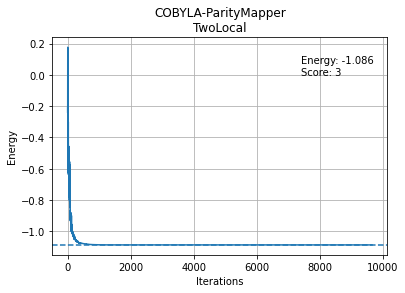

In [14]:
# Store results in a dictionary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# Unroller transpile your circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots

accuracy_threshold = 4.0 # in mHa
energy = result.optimal_value

if ansatz_type == "TwoLocal":
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': rotation_blocks,
        'entanglement_blocks': entanglement_blocks,
        'entanglement': entanglement,
        'repetitions': repetitions,
        'skip_final_rotation_layer': skip_final_rotation_layer,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}
else:
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': None,
        'entanglement_blocks': None,
        'entanglement': None,
        'repetitions': None,
        'skip_final_rotation_layer': None,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}

# Plot the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f})-\
Score({result_dict['score']:.0f})\
.png"
fig.savefig(fig_title, dpi=300)

# Display and save the data
import pandas as pd
import os.path
filename = 'results_h2.csv'
if os.path.isfile(filename):
    result_df = pd.read_csv(filename)
    result_df = result_df.append([result_dict])
else:
    result_df = pd.DataFrame.from_dict([result_dict])
result_df.to_csv(filename)
result_df[['optimizer','ansatz', '# of qubits', '# of parameters','rotation blocks', 'entanglement_blocks',
    'entanglement', 'repetitions', 'error (mHa)', 'pass', 'score']]